<a href="https://colab.research.google.com/github/monkrus/legal_llm/blob/main/finetune_pretrained_llm3_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach to fine tune pretrained modelwith added flowchart.

High accuracy (0.75-1)


To further improve 🍒 the model, one might consider:

**Data Augmentation**:e.g. synonym replacement or back-translation to artificially increase the size of your dataset.

**Cross-Validation**: Implement k-fold cross-validation to get a more robust estimate of performance.

**Pretrained Model**: using a model that has been pretrained on legal texts.

**Regularization**: Experiment with different dropout rates or L2 regularization to prevent overfitting.

**Learning Rate**: Try a slightly lower learning rate (e.g., 1e-5) given the small dataset size.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-3cd2fc2ab1de>:89: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.732800,0.595385,0.750000,0.562500,0.750000,0.642857
2,0.677200,0.599368,0.750000,0.562500,0.750000,0.642857
3,0.794700,0.605604,0.750000,0.562500,0.750000,0.642857
4,0.704800,0.619274,0.750000,0.562500,0.750000,0.642857
5,0.718500,0.634638,0.750000,0.562500,0.750000,0.642857
6,0.624600,0.638791,0.750000,0.562500,0.750000,0.642857
7,0.694300,0.636671,0.750000,0.875000,0.750000,0.766667
8,0.657400,0.622751,0.750000,0.875000,0.750000,0.766667
9,0.440200,0.616655,0.750000,0.875000,0.750000,0.766667
10,0.555400,0.563636,0.750000,0.875000,0.750000,0.766667


Validation Loss: 0.27427953481674194
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0


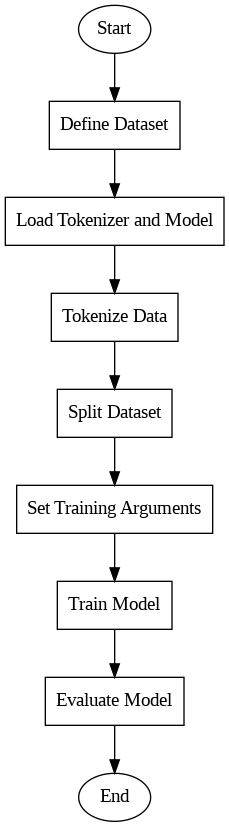

In [1]:
# Ensure required packages are installed
!apt-get install graphviz -y
!pip install torch==2.3.1+cu121 transformers datasets numpy graphviz pydot pyarrow==14.0.1 fsspec==2024.6.1 requests==2.31.0


# Import necessary libraries
import pydot
from IPython.display import Image
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
from sklearn.metrics import classification_report

# Define dataset
texts = [
    "Party A alleges a breach of contract due to non-delivery of goods.",
    "Party B is accused of fraud for misrepresenting financial information.",
    "Company C filed a lawsuit for intellectual property theft.",
    "Person D claims defamation in the recent publication.",
    "Party E is accused of breach of contract for late delivery.",
    "Person F alleges discrimination in the workplace.",
    "Company G sues for trademark infringement.",
    "Person H accuses the landlord of unlawful eviction.",
    "Party I is involved in a case of patent violation.",
    "Company J is accused of false advertising.",
    "Party K claims breach of warranty for defective products.",
    "Person L files a case for personal injury due to negligence.",
    "Company M is involved in a dispute over unpaid royalties.",
    "Party N alleges insider trading by corporate executives.",
    "Person O sues for emotional distress due to harassment.",
    "Organization P files a class-action lawsuit for data breach.",
    "Party Q accuses the company of wrongful termination.",
    "Person R claims copyright infringement for their creative work.",
    "Company S sues for breach of non-compete agreement.",
    "Party T is involved in a case of product liability."
]

labels = [
    0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
    0, 1, 0, 1, 1, 0, 1, 0, 1, 0
]

# Ensure labels match the number of texts
assert len(texts) == len(labels), "Number of texts and labels must match."

# Load the tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

# Convert texts to dataset
dataset = Dataset.from_dict({
    'text': texts,
    'label': labels
})

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Remove columns not needed for training
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

# Split the dataset into training and validation sets
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=4,  # Reduced due to small dataset size
    per_device_eval_batch_size=4,   # Reduced due to small dataset size
    warmup_steps=50,                # Reduced due to small dataset size
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,                # Log every step due to small dataset
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

# Load the accuracy metric
accuracy_metric = load_metric("accuracy")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']

    # Calculate classification report
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)

    # Extract scalar metrics
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
eval_result = trainer.evaluate()

print(f"Validation Loss: {eval_result['eval_loss']}")
print(f"Validation Accuracy: {eval_result['eval_accuracy']}")
print(f"Validation Precision: {eval_result['eval_precision']}")
print(f"Validation Recall: {eval_result['eval_recall']}")
print(f"Validation F1 Score: {eval_result['eval_f1']}")

# Create flowchart using pydot
graph = pydot.Dot(graph_type="digraph")

# Nodes
graph.add_node(pydot.Node("Start", shape="ellipse"))
graph.add_node(pydot.Node("Define Dataset", shape="box"))
graph.add_node(pydot.Node("Load Tokenizer and Model", shape="box"))
graph.add_node(pydot.Node("Tokenize Data", shape="box"))
graph.add_node(pydot.Node("Split Dataset", shape="box"))
graph.add_node(pydot.Node("Set Training Arguments", shape="box"))
graph.add_node(pydot.Node("Train Model", shape="box"))
graph.add_node(pydot.Node("Evaluate Model", shape="box"))
graph.add_node(pydot.Node("End", shape="ellipse"))

# Edges
graph.add_edge(pydot.Edge("Start", "Define Dataset"))
graph.add_edge(pydot.Edge("Define Dataset", "Load Tokenizer and Model"))
graph.add_edge(pydot.Edge("Load Tokenizer and Model", "Tokenize Data"))
graph.add_edge(pydot.Edge("Tokenize Data", "Split Dataset"))
graph.add_edge(pydot.Edge("Split Dataset", "Set Training Arguments"))
graph.add_edge(pydot.Edge("Set Training Arguments", "Train Model"))
graph.add_edge(pydot.Edge("Train Model", "Evaluate Model"))
graph.add_edge(pydot.Edge("Evaluate Model", "End"))

# Save and display the graph
graph.write_png("flowchart.png")
Image(filename="flowchart.png")